In [95]:
import glob
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
from torchvision.transforms import Compose, ToTensor, Resize, Normalize, RandomHorizontalFlip, ToPILImage
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader
import torchvision.models as models
import random
import os
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from IPython.core.debugger import set_trace
import pandas as pd
import datetime
import pytz
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import openpyxl
import torch.nn.functional as F

## 파라미터 설정

In [96]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [97]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [98]:
'''
# 맥 mps 설정
device = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")
print(f"현재 디바이스는 {device} 입니다.")
'''

'\n# 맥 mps 설정\ndevice = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")\nprint(f"현재 디바이스는 {device} 입니다.")\n'

In [99]:
CFG = {
    'IMG_SIZE':512,
    'EPOCHS':50,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE': 64,
    'SEED':41,
    'MEAN' : [0.485, 0.456, 0.406],
    'STD'  : [0.229, 0.224, 0.225],
    'train_magnification':"2.5X",
    'test_magnification':"2.5X",
}

In [100]:
kst = pytz.timezone('Asia/Seoul')
current_datetime = datetime.datetime.now(kst)
formatted_datetime = current_datetime.strftime("%Y_%m_%d_%I:%M_%p")
print(formatted_datetime)

2023_06_08_12:51_AM


In [101]:
'''
# server path
pth_name=f"/data/pthfile/train:{CFG['train_magnification']}_test:{CFG['test_magnification']}_epoch:{CFG['EPOCHS']}_({formatted_datetime}).pth"
output_name = f"train:{CFG['train_magnification']}_test:{CFG['test_magnification']}_epoch:{CFG['EPOCHS']}"
score_path = f"/data/output/Loss_Score"
plot_path = f"/data/output/plot/plot_{output_name}_({formatted_datetime})"
train_data_path = f"/data/PDA_mask_img/train/{CFG['train_magnification']}/**/*.png"
test_data_path = f"/data/PDA_mask_img/test_mask/{CFG['test_magnification']}/**/*.png"
val_data_path = f"/data/PDA_mask_img/validation_mask/{CFG['train_magnification']}/**/*.png"


print(f"pth_name:{pth_name}")
print(f"score_path:{score_path}")
print(f"plot_path:{plot_path}")
print(f"train_data_path:{train_data_path}")
print(f"test_data_path:{test_data_path}")
print(f"test_data_path:{val_data_path}")
'''

'\n# server path\npth_name=f"/data/pthfile/train:{CFG[\'train_magnification\']}_test:{CFG[\'test_magnification\']}_epoch:{CFG[\'EPOCHS\']}_({formatted_datetime}).pth"\noutput_name = f"train:{CFG[\'train_magnification\']}_test:{CFG[\'test_magnification\']}_epoch:{CFG[\'EPOCHS\']}"\nscore_path = f"/data/output/Loss_Score"\nplot_path = f"/data/output/plot/plot_{output_name}_({formatted_datetime})"\ntrain_data_path = f"/data/PDA_mask_img/train/{CFG[\'train_magnification\']}/**/*.png"\ntest_data_path = f"/data/PDA_mask_img/test_mask/{CFG[\'test_magnification\']}/**/*.png"\nval_data_path = f"/data/PDA_mask_img/validation_mask/{CFG[\'train_magnification\']}/**/*.png"\n\n\nprint(f"pth_name:{pth_name}")\nprint(f"score_path:{score_path}")\nprint(f"plot_path:{plot_path}")\nprint(f"train_data_path:{train_data_path}")\nprint(f"test_data_path:{test_data_path}")\nprint(f"test_data_path:{val_data_path}")\n'

In [102]:
# local path
pth_name=f"git_ignore/pthfile/train:{CFG['train_magnification']}_test:{CFG['test_magnification']}_epoch:{CFG['EPOCHS']}_({formatted_datetime}).pth"
output_name = f"train:{CFG['train_magnification']}_test:{CFG['test_magnification']}_epoch:{CFG['EPOCHS']}"
score_path = f"git_ignore/output/Loss_Score/score_{output_name}_({formatted_datetime})"
plot_path = f"git_ignore/output/plot/plot_{output_name}_({formatted_datetime})"
train_data_path = f"git_ignore/PDA_mask_img/train/{CFG['train_magnification']}/**/*.png"
test_data_path = f"git_ignore/PDA_mask_img/test_mask/{CFG['test_magnification']}/**/*.png"
val_data_path = f"git_ignore/PDA_mask_img/validation_mask/{CFG['train_magnification']}/**/*.png"


print(f"pth_name:{pth_name}")
print(f"score_path:{score_path}")
print(f"plot_path:{plot_path}")
print(f"train_data_path:{train_data_path}")
print(f"test_data_path:{test_data_path}")
print(f"test_data_path:{val_data_path}")

pth_name:git_ignore/pthfile/train:2.5X_test:2.5X_epoch:50_(2023_06_08_12:51_AM).pth
score_path:git_ignore/output/Loss_Score/score_train:2.5X_test:2.5X_epoch:50_(2023_06_08_12:51_AM)
plot_path:git_ignore/output/plot/plot_train:2.5X_test:2.5X_epoch:50_(2023_06_08_12:51_AM)
train_data_path:git_ignore/PDA_mask_img/train/2.5X/**/*.png
test_data_path:git_ignore/PDA_mask_img/test_mask/2.5X/**/*.png
test_data_path:git_ignore/PDA_mask_img/validation_mask/2.5X/**/*.png


In [103]:
# 시드 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## 데이터 경로지정

In [104]:
train_path_list = sorted(glob.glob(train_data_path))
train_mask_path = train_path_list[0::2]
train_img_path = train_path_list[1::2]
train_mask_path[:5]

['git_ignore/PDA_mask_img/train/2.5X/C3L-00017-22/C3L-00017-22 [d=8.09389,x=0,y=6362,w=4144,h=4144]-labelled.png',
 'git_ignore/PDA_mask_img/train/2.5X/C3L-00017-22/C3L-00017-22 [d=8.09389,x=0,y=8482,w=4144,h=4144]-labelled.png',
 'git_ignore/PDA_mask_img/train/2.5X/C3L-00017-22/C3L-00017-22 [d=8.09389,x=10603,y=10603,w=4144,h=4144]-labelled.png',
 'git_ignore/PDA_mask_img/train/2.5X/C3L-00017-22/C3L-00017-22 [d=8.09389,x=10603,y=12724,w=4144,h=4144]-labelled.png',
 'git_ignore/PDA_mask_img/train/2.5X/C3L-00017-22/C3L-00017-22 [d=8.09389,x=10603,y=14844,w=4144,h=4144]-labelled.png']

In [105]:
test_path_list = sorted(glob.glob(test_data_path))
test_mask_path = test_path_list[0::2]
test_img_path = test_path_list[1::2]
test_mask_path[:5]

['git_ignore/PDA_mask_img/test_mask/2.5X/C3L-01637-21/C3L-01637-21 [d=8.09389,x=0,y=4144,w=4144,h=4144]-labelled.png',
 'git_ignore/PDA_mask_img/test_mask/2.5X/C3L-01637-21/C3L-01637-21 [d=8.09389,x=4144,y=0,w=4144,h=4144]-labelled.png',
 'git_ignore/PDA_mask_img/test_mask/2.5X/C3L-01637-21/C3L-01637-21 [d=8.09389,x=4144,y=4144,w=4144,h=4144]-labelled.png',
 'git_ignore/PDA_mask_img/test_mask/2.5X/C3L-01637-21/C3L-01637-21 [d=8.09389,x=4144,y=8288,w=4144,h=4144]-labelled.png',
 'git_ignore/PDA_mask_img/test_mask/2.5X/C3L-01637-21/C3L-01637-21 [d=8.09389,x=8288,y=0,w=4144,h=4144]-labelled.png']

In [106]:
val_path_list = sorted(glob.glob(val_data_path))
val_mask_path = val_path_list[0::2]
val_img_path = val_path_list[1::2]
val_mask_path[:5]

['git_ignore/PDA_mask_img/validation_mask/2.5X/C3L-00277-22/C3L-00277-22 [d=8.09389,x=0,y=16576,w=4144,h=4144]-labelled.png',
 'git_ignore/PDA_mask_img/validation_mask/2.5X/C3L-00277-22/C3L-00277-22 [d=8.09389,x=0,y=20720,w=4144,h=4144]-labelled.png',
 'git_ignore/PDA_mask_img/validation_mask/2.5X/C3L-00277-22/C3L-00277-22 [d=8.09389,x=12432,y=12432,w=4144,h=4144]-labelled.png',
 'git_ignore/PDA_mask_img/validation_mask/2.5X/C3L-00277-22/C3L-00277-22 [d=8.09389,x=12432,y=16576,w=4144,h=4144]-labelled.png',
 'git_ignore/PDA_mask_img/validation_mask/2.5X/C3L-00277-22/C3L-00277-22 [d=8.09389,x=12432,y=20720,w=4144,h=4144]-labelled.png']

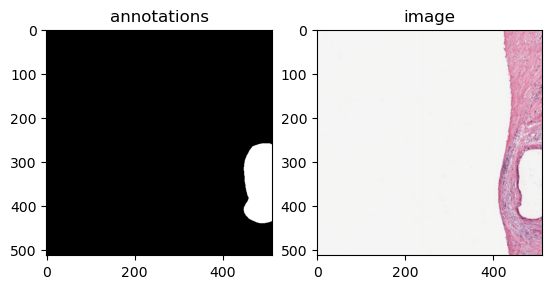

In [107]:
annotation = cv2.imread(train_mask_path[0])
image = cv2.imread(train_img_path[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.subplot(1,2,1)
plt.title("annotations")
plt.imshow(annotation)

plt.subplot(1,2,2)
plt.title("image")
plt.imshow(image)

In [108]:
# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, img_path, mask_path, transform = None):
        self.image = img_path
        self.mask = mask_path
        
        n_samples =  len(self.image)
        
        # 데이터 미리 섞어줌
        np.random.seed(CFG['SEED'])
        idxs = np.random.permutation(range(n_samples))
        
        self.image = np.array(self.image)[idxs]
        self.mask = np.array(self.mask)[idxs]
        self.transform = transform

    def __len__(self):
        return len(self.image) # 데이터셋 길이
    
    def __getitem__(self, i):
        image = np.array(Image.open(self.image[i]))
        mask = np.array(Image.open(self.mask[i]))
        data = self.transform(image = image, mask = mask)
        image = data["image"]
        mask = data["mask"]
        return image, mask

In [109]:
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.encoder = models.resnet18(pretrained=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU(inplace=True)
        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.encoder.conv1(x)
        x1 = self.encoder.bn1(x1)
        x1 = self.encoder.relu(x1)
        x1 = self.encoder.maxpool(x1)

        x2 = self.encoder.layer1(x1)
        x3 = self.encoder.layer2(x2)
        x4 = self.encoder.layer3(x3)
        x5 = self.encoder.layer4(x4)

        # Decoder
        x = self.upconv1(x5)
        x = torch.cat((x, x4), dim=1)
        x = self.relu(self.conv1(x))

        x = self.upconv2(x)
        x = torch.cat((x, x3), dim=1)
        x = self.relu(self.conv2(x))

        x = self.upconv3(x)
        x = torch.cat((x, x2), dim=1)
        x = self.relu(self.conv3(x))

        x = self.conv4(x)

        # Resize to 512x512
        x = nn.functional.interpolate(x, size=(512, 512), mode='bilinear', align_corners=False)

        return x

## 데이터 불러오기

In [110]:
train_transform = A.Compose([
        A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
        A.Normalize(mean=CFG['MEAN'], std = CFG['STD']),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        A.OneOf([
                A.HorizontalFlip(p=0.3),
                A.RandomRotate90(p=0.3),
                A.VerticalFlip(p=0.3)            
        ], p=0.3),
        ToTensorV2(transpose_mask=True)
])

'''
A.OneOf([
        A.MotionBlur(p=0.3),
        A.OpticalDistortion(p=0.3),
        A.GaussNoise(p=0.3)                 
], p=0.3),
'''

'\nA.OneOf([\n        A.MotionBlur(p=0.3),\n        A.OpticalDistortion(p=0.3),\n        A.GaussNoise(p=0.3)                 \n], p=0.3),\n'

In [111]:
test_transform = A.Compose([
        A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
        A.Normalize(mean=CFG['MEAN'], std = CFG['STD']),
        ToTensorV2(transpose_mask=True)
])

In [112]:
# 학습용 데이터
train_set = CustomDataset(img_path = train_img_path,
                          mask_path = train_mask_path,
                          transform = train_transform)

val_set = CustomDataset(img_path = val_img_path,
                         mask_path= val_mask_path,
                         transform = test_transform)
# 테스트 데이터
test_set = CustomDataset(img_path = test_img_path,
                         mask_path=test_mask_path,
                         transform = test_transform)

In [113]:
train_loader = DataLoader(train_set, batch_size = CFG["BATCH_SIZE"], shuffle = True)
val_loader = DataLoader(val_set, batch_size = CFG["BATCH_SIZE"])
test_loader = DataLoader(test_set, batch_size = CFG["BATCH_SIZE"])

In [114]:
print(f"train_data : {len(train_set)} / val_data : {len(val_set)} / test_data : {len(test_set)}")

train_data : 228 / val_data : 23 / test_data : 6


## 학습

In [198]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        inputs = F.sigmoid(inputs) # sigmoid를 통과한 출력이면 주석처리
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice 

In [199]:
# 학습 파라미터
model = UNet(num_classes=1).to(device)
model = nn.DataParallel(model)
optimizer = Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)
criterion = DiceLoss().to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [200]:
def dice_score(pred, target, smooth=1e-6):
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

In [201]:
# 평균값 계산
class AverageMeter: 
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [202]:
class EarlyStop:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_score):
        if self.best_score is None:
            self.best_score = val_score
        elif val_score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_score
            self.counter = 0

In [203]:
loss_meter = AverageMeter()
score_meter = AverageMeter()
early_stopping = EarlyStop(patience = 20, delta = 0)

In [204]:
def validation(model, criterion, val_loader, device):
    model.eval()
    with torch.no_grad():
        for img, label in tqdm(val_loader):
            out = model(img.to(device))
            out = torch.squeeze(out)
            pred = torch.ge(out.sigmoid(), 0.5).float()
            label = torch.squeeze(label).to(device)
            score = dice_score(pred, label)
            loss = criterion(out, label.type(torch.FloatTensor).to(device))

            loss_meter.update(loss.item())
            score_meter.update(score.item())

        val_loss_mean = loss_meter.avg
        val_score_mean = score_meter.avg
        loss_meter.reset()
        score_meter.reset()
    return val_loss_mean, val_score_mean

In [205]:
def train(model, criterion, optimizer, train_loader, val_loader, scheduler, device):
    best_score = 0
    best_model = None
    result_arr = np.empty((0,4), float)
    columns = []
    model.train()
    for epoch in range(CFG["EPOCHS"]):
        try:
            for img, label in tqdm(train_loader):
                optimizer.zero_grad()
                out = model(img.to(device))
                out = torch.squeeze(out)
                pred = torch.ge(out.sigmoid(), 0.5).float()
                label = torch.squeeze(label).to(device)
                score = dice_score(pred, label)
                loss = criterion(out, label.type(torch.FloatTensor).to(device))

                loss_meter.update(loss.item())
                score_meter.update(score.item())

                loss.backward()
                optimizer.step()
                
            train_loss_mean = loss_meter.avg
            train_score_mean = score_meter.avg
            loss_meter.reset()
            score_meter.reset()
            val_loss, val_score = validation(model, criterion, val_loader, device)

            print(f"epoch{epoch+1}: Train_loss:{train_loss_mean} Train_score:{train_score_mean} Val_loss:{val_loss} Val_score:{val_score}")
            result_arr = np.append(result_arr, np.array([[train_loss_mean,train_score_mean, val_loss, val_score]]), axis = 0)
            if scheduler is not None:
                scheduler.step(val_score)
                  
            if best_score < val_score:
                best_score = val_score
                best_model = model
                
            early_stopping(val_score)
            if early_stopping.early_stop:
                columns.append(f"epoch:{epoch+1}")
                print("Early stopping!")
                break
        except KeyboardInterrupt:
            best_model = model
        columns.append(f"epoch:{epoch+1}")
    return best_model, result_arr, columns

## Run

In [30]:
infer_model, result, columns = train(model, criterion, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch1: Train_loss:0.9423257231712341 Train_score:0.1191076397895813 Val_loss:0.9282055497169495 Val_score:0.17908000946044922


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch2: Train_loss:0.939379894733429 Train_score:0.13982914462685586 Val_loss:0.9188417792320251 Val_score:0.1855139583349228


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch3: Train_loss:0.9253128409385681 Train_score:0.13294050693511963 Val_loss:0.8907870650291443 Val_score:0.14869853854179382


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch4: Train_loss:0.9060354471206665 Train_score:0.13668514788150787 Val_loss:0.8732247352600098 Val_score:0.25083646178245544


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch5: Train_loss:0.8940851926803589 Train_score:0.1730954170227051 Val_loss:0.8475487232208252 Val_score:0.22588089108467102


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch6: Train_loss:0.8716628074645996 Train_score:0.1882210612297058 Val_loss:0.8037372827529907 Val_score:0.28432658314704895


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch7: Train_loss:0.8536511421203613 Train_score:0.19618649538606406 Val_loss:0.7522713541984558 Val_score:0.28641483187675476


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch8: Train_loss:0.8196867108345032 Train_score:0.22763811349868773 Val_loss:0.7757902145385742 Val_score:0.23527345061302185


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch9: Train_loss:0.8209541320800782 Train_score:0.18741483390331268 Val_loss:0.7121372222900391 Val_score:0.325357586145401


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch10: Train_loss:0.775936508178711 Train_score:0.2229809992015362 Val_loss:0.7092995643615723 Val_score:0.300775945186615


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch11: Train_loss:0.7952760934829712 Train_score:0.2115519478917122 Val_loss:0.7468382120132446 Val_score:0.25412607192993164


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch12: Train_loss:0.8066982626914978 Train_score:0.19375663697719575 Val_loss:0.7166542410850525 Val_score:0.28816789388656616
Epoch 00012: reducing learning rate of group 0 to 5.0000e-05.


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch13: Train_loss:0.8208000540733338 Train_score:0.16508877066662536 Val_loss:0.7190430164337158 Val_score:0.2856544852256775


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch14: Train_loss:0.7547554135322571 Train_score:0.2512374438345432 Val_loss:0.732578694820404 Val_score:0.27053970098495483


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch15: Train_loss:0.7831813573837281 Train_score:0.21949816644191741 Val_loss:0.7425256371498108 Val_score:0.2667272984981537
Epoch 00015: reducing learning rate of group 0 to 2.5000e-05.


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch16: Train_loss:0.7664194703102112 Train_score:0.25653803125023844 Val_loss:0.7447776794433594 Val_score:0.26657378673553467


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch17: Train_loss:0.7767355084419251 Train_score:0.2341076873242855 Val_loss:0.7330923080444336 Val_score:0.2712305784225464


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch18: Train_loss:0.7593423843383789 Train_score:0.24868523180484772 Val_loss:0.7307018637657166 Val_score:0.2729690968990326
Epoch 00018: reducing learning rate of group 0 to 1.2500e-05.


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch19: Train_loss:0.7514586925506592 Train_score:0.25704007148742675 Val_loss:0.7292638421058655 Val_score:0.27540305256843567


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch20: Train_loss:0.7492264151573181 Train_score:0.26376849561929705 Val_loss:0.7296237945556641 Val_score:0.2789610028266907


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch21: Train_loss:0.7305923938751221 Train_score:0.30431071370840074 Val_loss:0.7295126914978027 Val_score:0.28015074133872986
Epoch 00021: reducing learning rate of group 0 to 6.2500e-06.


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch22: Train_loss:0.7300073027610778 Train_score:0.2960523650050163 Val_loss:0.7267400622367859 Val_score:0.28206008672714233


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch23: Train_loss:0.7264844417572022 Train_score:0.28978596329689027 Val_loss:0.7244489192962646 Val_score:0.28350022435188293


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch24: Train_loss:0.724093246459961 Train_score:0.2882749758660793 Val_loss:0.7249590158462524 Val_score:0.2831963300704956
Epoch 00024: reducing learning rate of group 0 to 3.1250e-06.


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch25: Train_loss:0.7458786487579345 Train_score:0.26459635347127913 Val_loss:0.7263747453689575 Val_score:0.2843337953090668


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch26: Train_loss:0.7602222561836243 Train_score:0.24838037528097628 Val_loss:0.7279654741287231 Val_score:0.28249257802963257


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch27: Train_loss:0.7359941124916076 Train_score:0.29015429615974425 Val_loss:0.7297107577323914 Val_score:0.28268876671791077
Epoch 00027: reducing learning rate of group 0 to 1.5625e-06.


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch28: Train_loss:0.7401815891265869 Train_score:0.290051418915391 Val_loss:0.7313088178634644 Val_score:0.28231826424598694


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch29: Train_loss:0.7208693265914917 Train_score:0.3101338632404804 Val_loss:0.7328327894210815 Val_score:0.2809297442436218
Early stopping!


## 결과 그래프

In [31]:
result_df = pd.DataFrame(data = result, index = columns, columns = ["Train Loss", "Train Dice Score", "Validation Loss", "Validation Dice Score"])
result_df.tail()

,Train Loss,Train Dice Score,Validation Loss,Validation Dice Score
epoch:25,0.745879,0.264596,0.726375,0.284334
epoch:26,0.760222,0.248380,0.727965,0.282493
epoch:27,0.735994,0.290154,0.729711,0.282689
epoch:28,0.740182,0.290051,0.731309,0.282318
epoch:29,0.720869,0.310134,0.732833,0.280930


<Axes: >

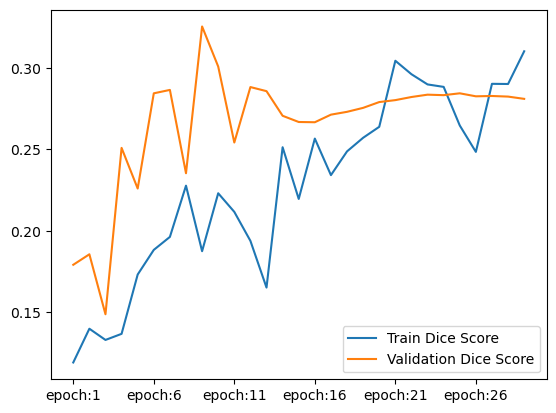

In [32]:
result_df[["Train Dice Score", "Validation Dice Score"]].plot()

<Axes: >

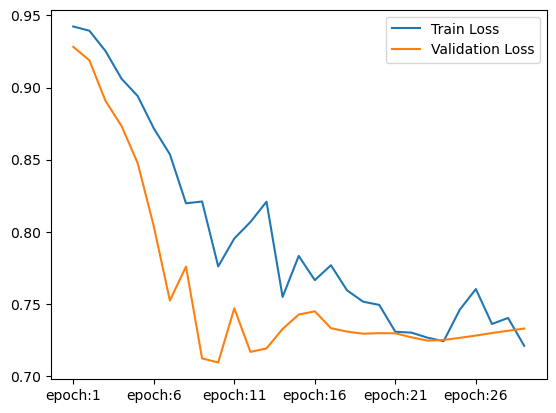

In [33]:
result_df[["Train Loss", "Validation Loss"]].plot()

In [34]:
# 모델 저장
torch.save(infer_model.state_dict(), pth_name)

## Test

In [206]:
def Test(model, criterion, test_loader, device):
    model.eval()
    with torch.no_grad():
        for img, label in tqdm(test_loader):
            out = model(img.to(device))
            out = torch.squeeze(out)
            pred = torch.ge(out.sigmoid(), 0.5).float()
            label = torch.squeeze(label).to(device)
            score = dice_score(pred, label)
            loss = criterion(out, label.type(torch.FloatTensor).to(device))

            loss_meter.update(loss.item())
            score_meter.update(score.item())
    
        test_loss_mean = loss_meter.avg
        test_score_mean = score_meter.avg
        loss_meter.reset()
        score_meter.reset()
    
    return test_loss_mean, test_score_mean

In [207]:
# 다른 배율 테스트 시
model.load_state_dict(torch.load("data/pthfile/train:20X_test:20X_epoch:50_(2023_06_07_03:24_PM).pth", map_location=device))
test_loss, test_score = Test(model, criterion, test_loader, device)
result_df = pd.DataFrame({"Test Loss":[f"Test Loss: {test_loss}"],"Test Score":[f"Test Score: {test_score}"]}, index = ["Test"])
print(f"test_loss: {test_loss}, test_score: {test_score}")

  0%|          | 0/1 [00:00<?, ?it/s]

test_loss: 0.7769953012466431, test_score: 0.22292211651802063


In [111]:
'''
# 같은 배율 테스트 시
test_loss, test_score = Test(infer_model, criterion, test_loader, device)
result_df.loc["Test"] = [f"Test Loss: {test_loss}",f"Test Score: {test_score}",'X','X']
print(f"test_loss: {test_loss}, test_score: {test_score}")
'''

  0%|          | 0/30 [00:00<?, ?it/s]

test_loss: 0.28426844676335655, test_score: 0.715787672996521


In [208]:
result_df.tail()

,Test Loss,Test Score
Test,Test Loss: 0.7769953012466431,Test Score: 0.22292211651802063


In [209]:
result_df.to_excel(f"{score_path}/{output_name}.xlsx")

## 결과 저장

In [210]:
def denormalize(tensor, mean=CFG["MEAN"], std=CFG["STD"]):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

In [211]:
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'inferno'

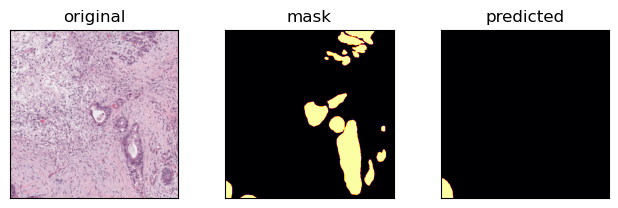

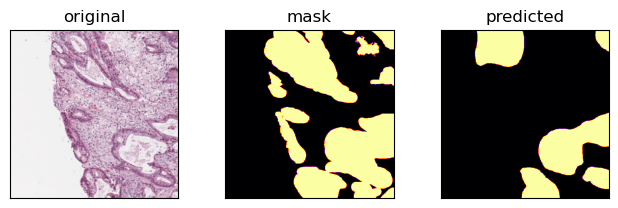

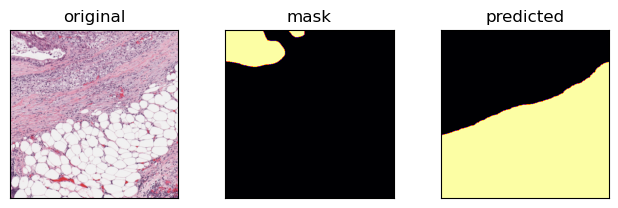

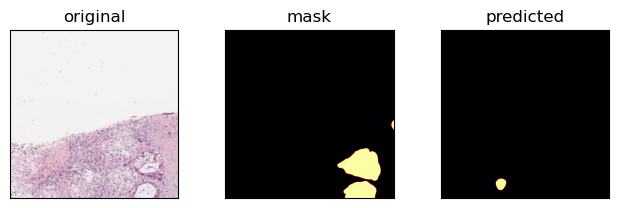

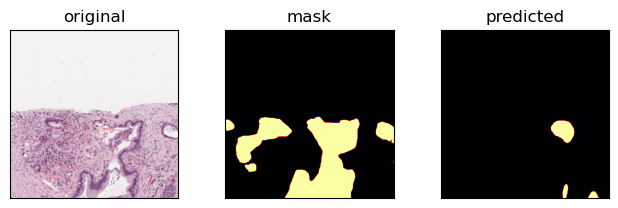

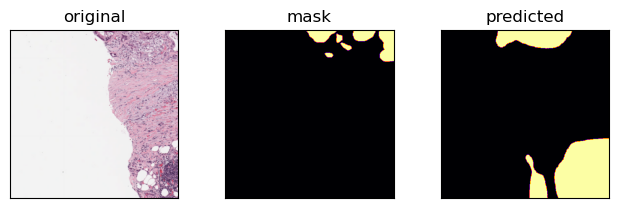

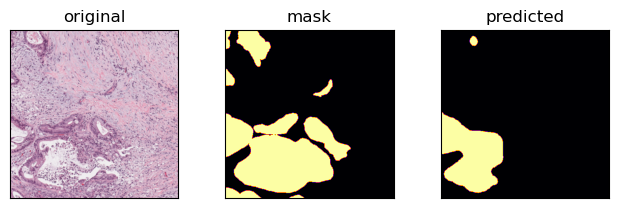

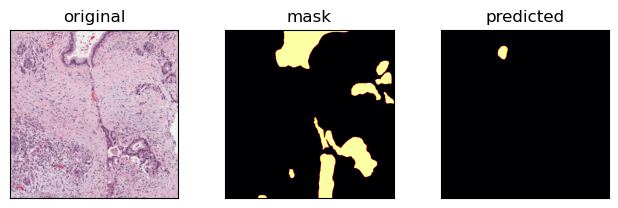

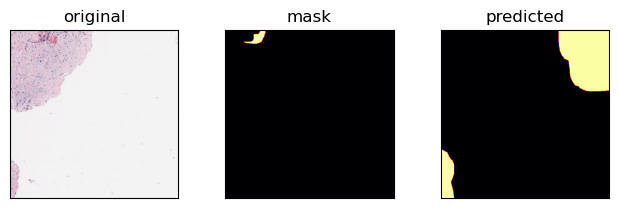

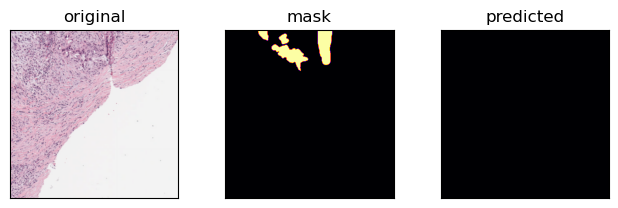

In [212]:
# output_save
os.makedirs(plot_path, exist_ok=True)

for i in range(10):
    
    data, label = test_set[i]
    label = torch.squeeze(label)

    with torch.no_grad():
        out = model(torch.unsqueeze(data, dim=0).to(device))
    out = torch.squeeze(out).sigmoid().to('cpu')
    pred = torch.ge(out, 0.5).float().to('cpu')

    # 오리지널 이미지
    plt.subplot(1,3,1)
    plt.title("original")
    plt.imshow(ToPILImage()(denormalize(data)))
    plt.xticks([]); plt.yticks([])

    # 마스크 이미지
    plt.subplot(1,3,2)
    plt.title("mask")
    plt.imshow(label)
    plt.xticks([]); plt.yticks([])
    
    # 마스크 예측 이미지
    plt.subplot(1,3,3)
    plt.title("predicted")
    plt.tight_layout()
    plt.imshow(pred)
    plt.xticks([]); plt.yticks([])

    plt.savefig(f'{plot_path}/{output_name}_{i+1}.png', bbox_inches = 'tight')
    plt.show()